<a href="https://colab.research.google.com/github/nPr0nn/Machine-Learning-Playground/blob/main/segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing

In [1]:
pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

# Dataset

In [4]:
# Import the dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## Preprocessing and display functions

In [5]:
# Normalize image so that the pixels are between 0 and 1
# Subtract 1 from mask so that values are 0, 1 or 2
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

# Load images from the dataset
@tf.function
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

## Load images

In [6]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_images  = dataset['test'].map(load_image)

In [7]:
train_dataset = train_images.cache().shuffle(1000).batch(64).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset  = test_images.batch(64)

## Display

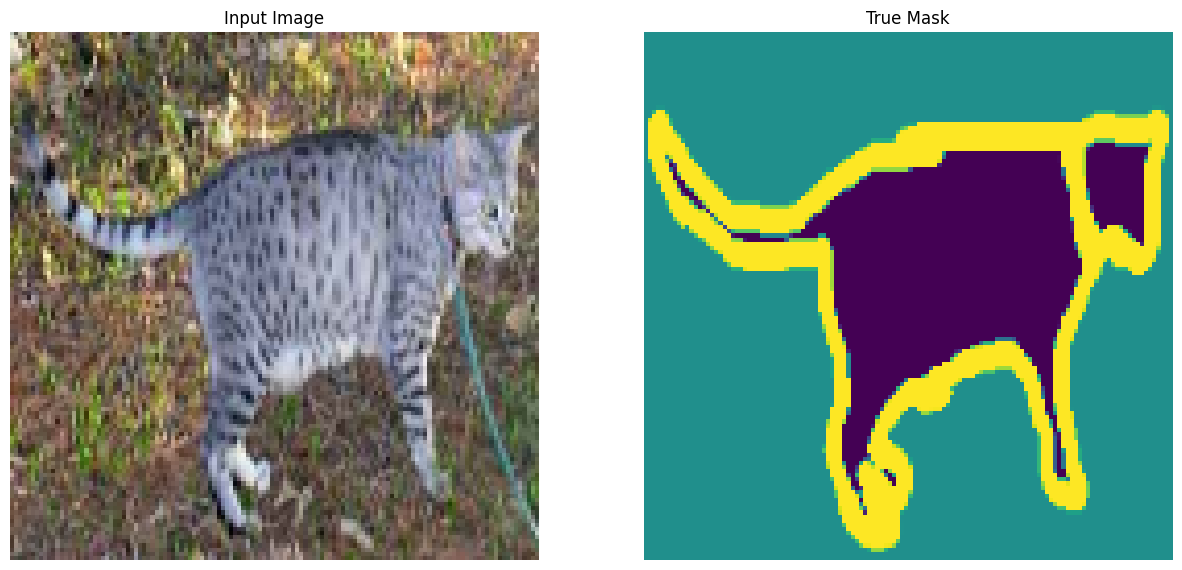

In [8]:
i = 100
for image, mask in train_images.take(i):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# Unet


In [26]:
img_shape = [128, 128, 3]

In [27]:
# Down Stack
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model  = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False)
layers      = [base_model.get_layer(name).output for name in layer_names]
down_stack  = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False


In [28]:
# Up Stack
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [30]:
def unet(output_channels):

  # Input layer
  inputs       = tf.keras.layers.Input(shape=img_shape)
  x            = inputs

  # Downsampling
  skips = down_stack(x)
  x     = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Last layer
  last_layer = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same', activation='softmax')  #64x64 -> 128x128
  x = last_layer(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [31]:
CLASSES_NUMBER = 3
model = unet(CLASSES_NUMBER)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

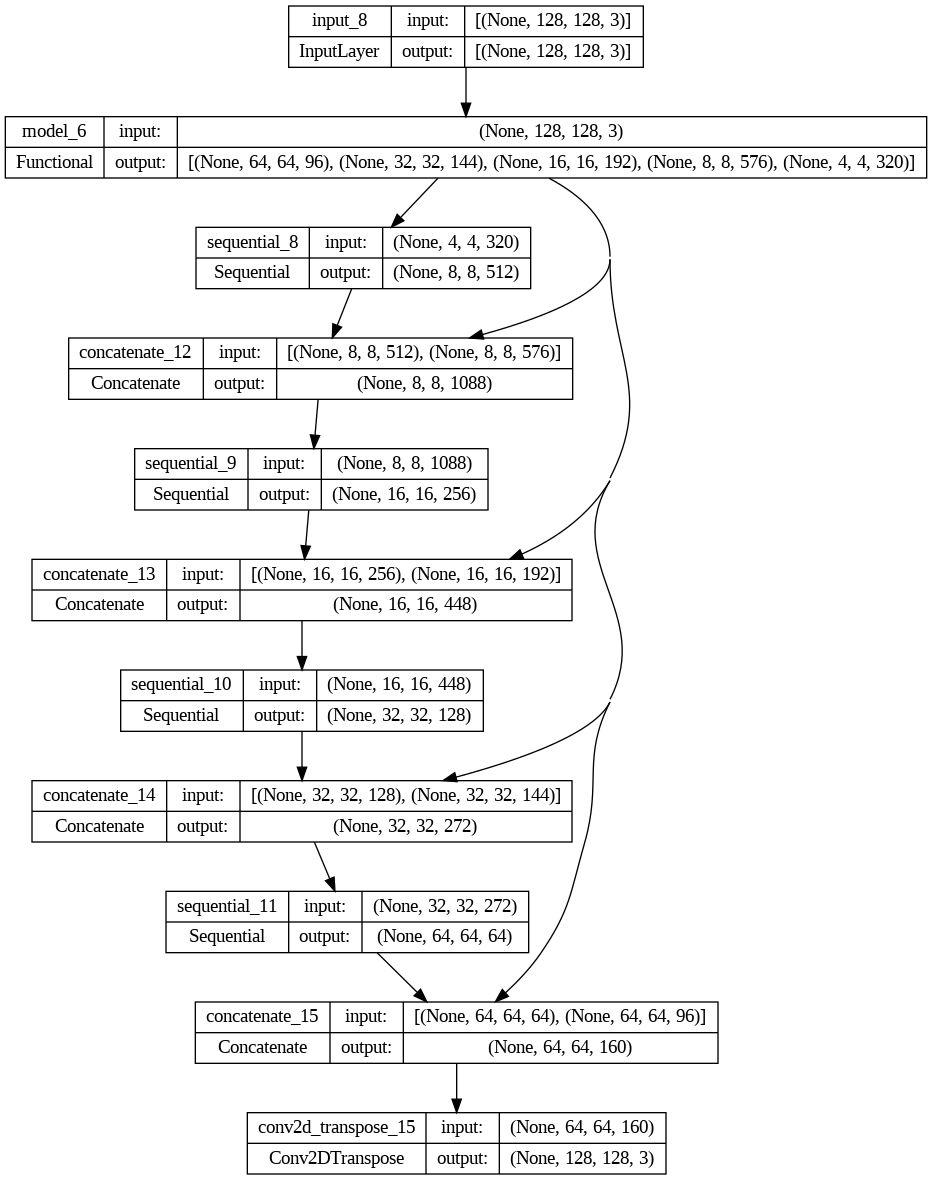

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [33]:
# Trainning
TRAIN_LENGTH = info.splits['train'].num_examples
TEST_LENGTH  = info.splits['test'].num_examples

BATCH_SIZE   = 64
STEPS        = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLIT = 5
VAL_STEPS    = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLIT

EPOCHS       = 10

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS, validation_steps=VAL_STEPS, validation_data=test_dataset)

Epoch 1/10
57/57 [==============================] - 62s 1s/step - loss: 0.4790 - accuracy: 0.8051 - val_loss: 0.6156 - val_accuracy: 0.7942
Epoch 2/10
57/57 [==============================] - 9s 161ms/step - loss: 0.2972 - accuracy: 0.8788 - val_loss: 0.3292 - val_accuracy: 0.8723
Epoch 3/10
57/57 [==============================] - 10s 168ms/step - loss: 0.2726 - accuracy: 0.8872 - val_loss: 0.3017 - val_accuracy: 0.8753
Epoch 4/10
57/57 [==============================] - 10s 178ms/step - loss: 0.2601 - accuracy: 0.8912 - val_loss: 0.2762 - val_accuracy: 0.8889
Epoch 5/10
57/57 [==============================] - 9s 167ms/step - loss: 0.2498 - accuracy: 0.8946 - val_loss: 0.2785 - val_accuracy: 0.8864
Epoch 6/10
57/57 [==============================] - 10s 168ms/step - loss: 0.2408 - accuracy: 0.8978 - val_loss: 0.2763 - val_accuracy: 0.8879
Epoch 7/10
57/57 [==============================] - 9s 160ms/step - loss: 0.2305 - accuracy: 0.9015 - val_loss: 0.2731 - val_accuracy: 0.8898
Epoch

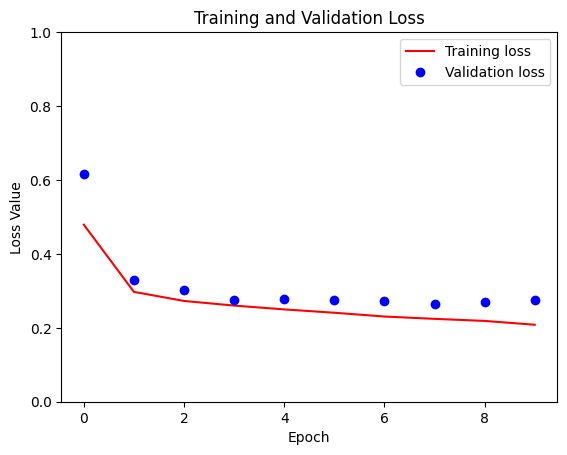

In [34]:
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Display predictions

In [35]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 0s 47ms/step


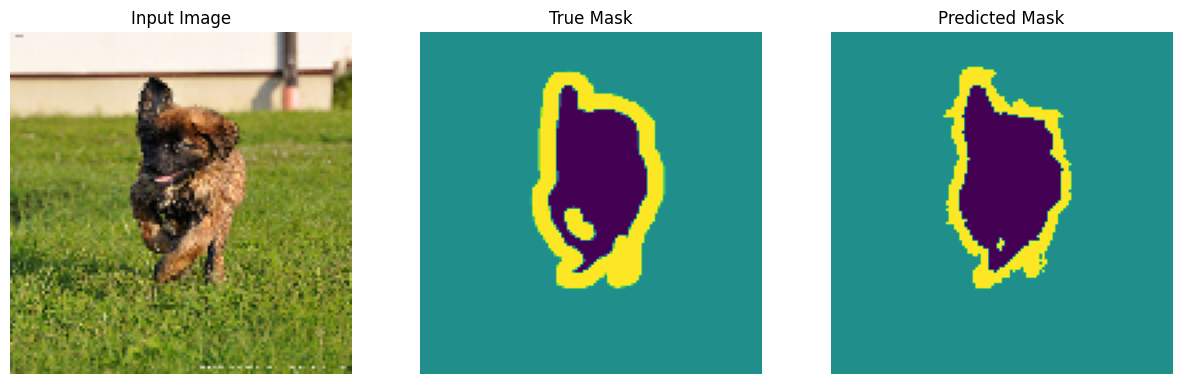

2/2 [==============================] - 0s 57ms/step


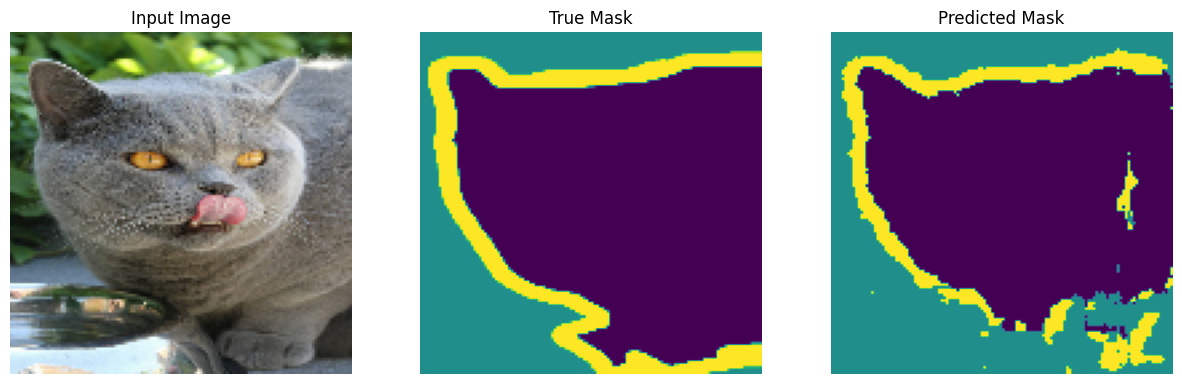

2/2 [==============================] - 0s 43ms/step


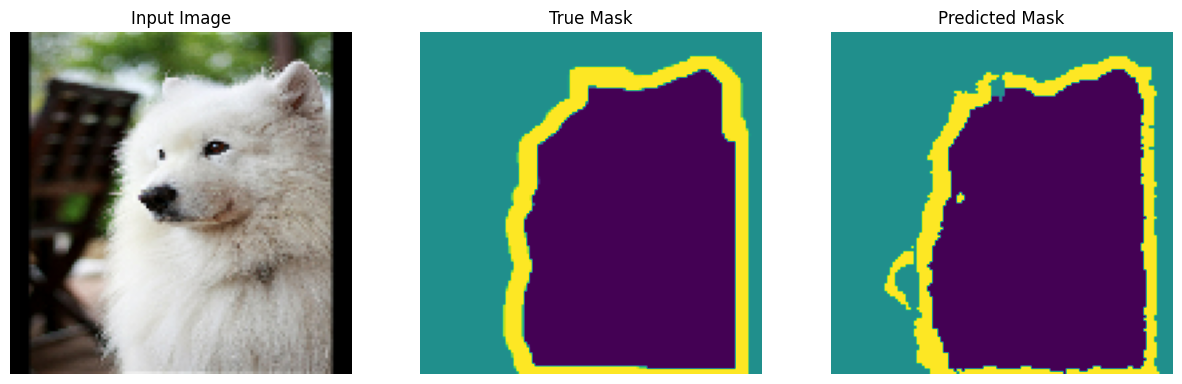

2/2 [==============================] - 0s 45ms/step


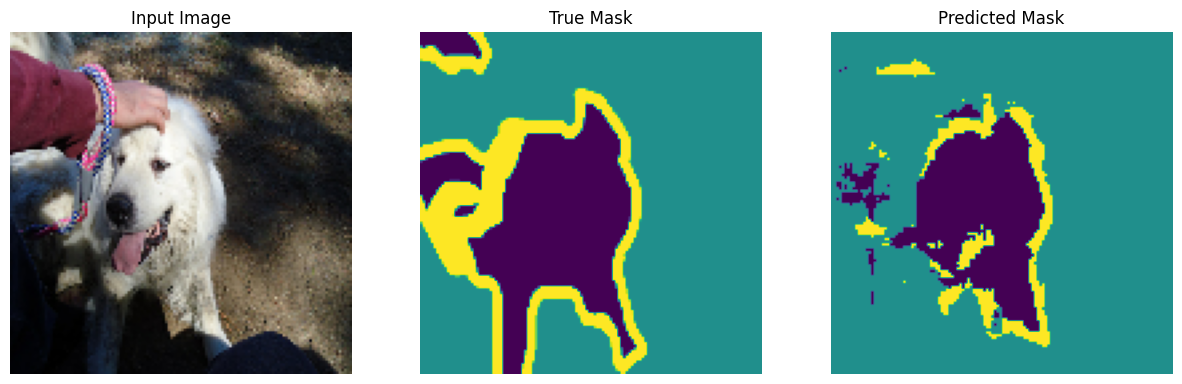

2/2 [==============================] - 0s 45ms/step


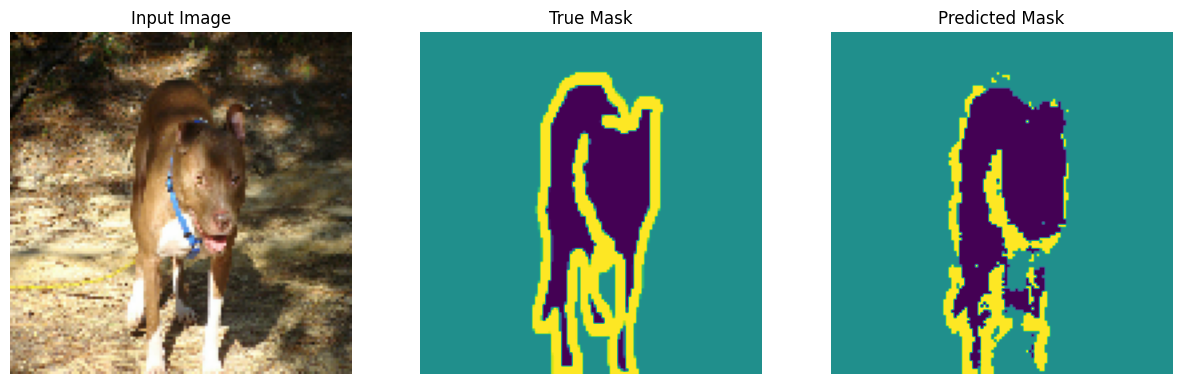

2/2 [==============================] - 0s 44ms/step


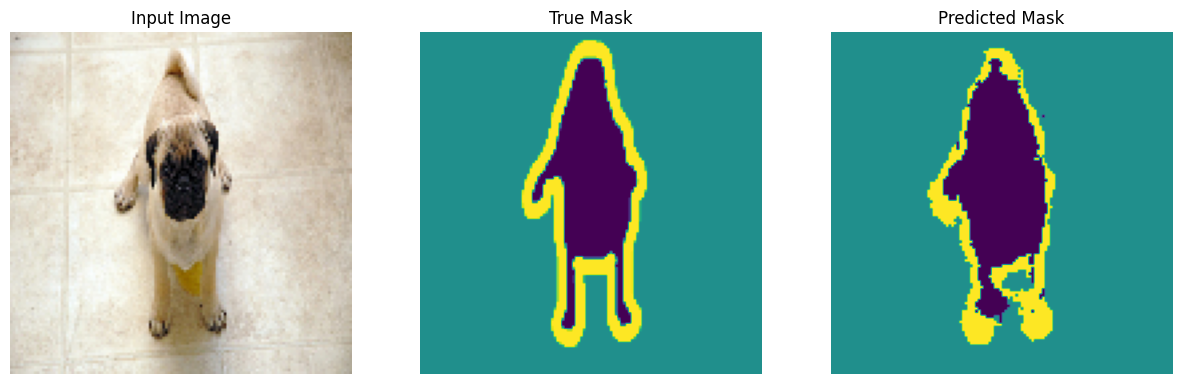

2/2 [==============================] - 0s 54ms/step


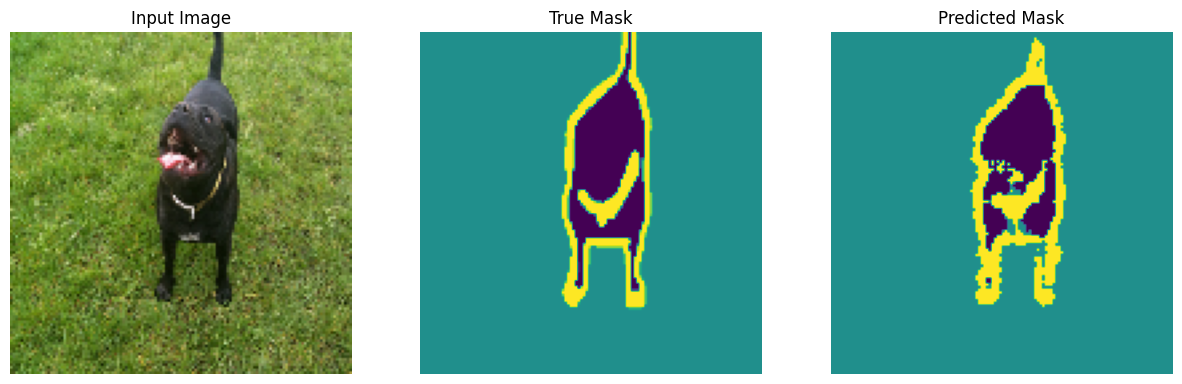

2/2 [==============================] - 0s 44ms/step


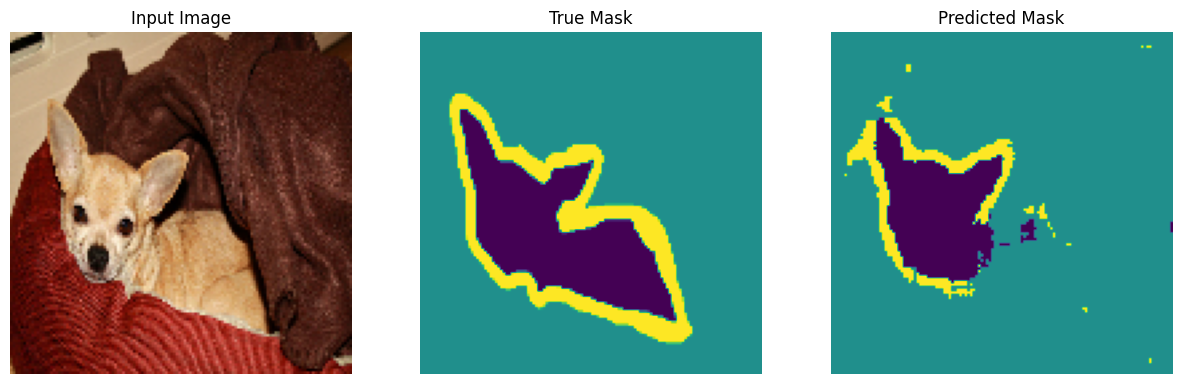

2/2 [==============================] - 0s 43ms/step


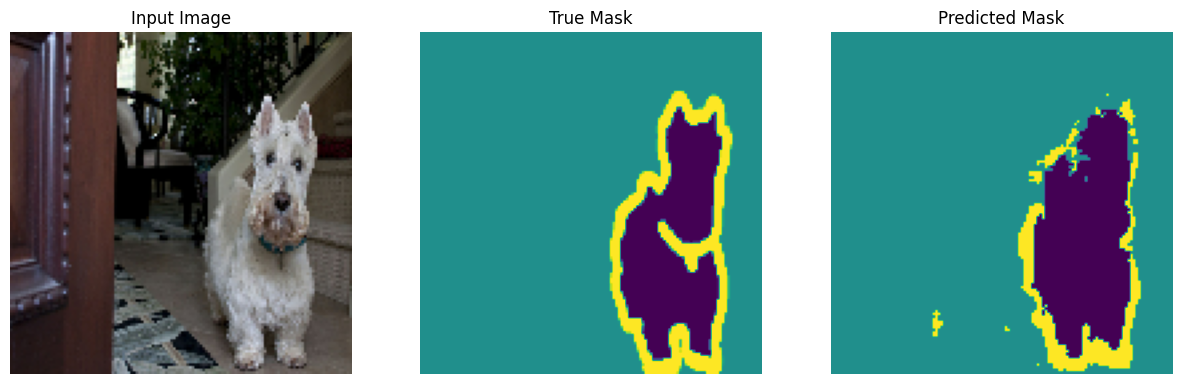

2/2 [==============================] - 0s 46ms/step


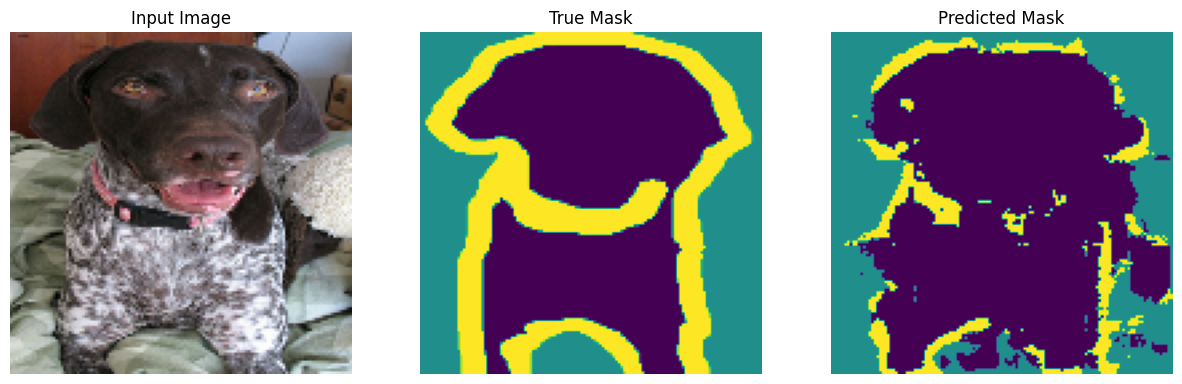

In [37]:
show_predictions(test_dataset, 10)